<a href="https://colab.research.google.com/github/Neuralwood-Net/woodnet/blob/main/notebooks/training-and-plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train networks on 224px color images
### Notebook for training WoodNet and SqueezeNet on both the images cropped around center and the images cropped to faces



### Make sure the hardware is in order

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Nov 20 07:25:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Imports

In [2]:
import time
import os
import copy
import sys
import tarfile
import zipfile

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import torchvision
from torchvision import datasets, models, transforms

from google.cloud import storage

# Placeholder to make it run until the real WoodNet is defined
class WoodNet:
    pass

# Define an enumeration type for the different datasets
# (easily extendable to more sets in the future)
class Dataset:
    CENTER = 0
    FACE = 1

# Define enumration type for the different networks
class Network:
    WOODNET = 0
    SQUEEZENET = 1
    BADNET = 2

# Set what device to run the training on (preferrably GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Create configurations for the different datasets

In [3]:
# Define some configuration for the different datasets so the below code will work
configuration = {
    Dataset.CENTER: {
        "blobname": "faces/balanced_sampled_224px_color_156240_images_70_15_15_split.zip",
        "datadir": "sampled_dataset_balanced_244",
    },
    Dataset.FACE: {
        "blobname": "faces/balanced_sampled_cropped_224px_color_70_15_15_split.tar.gz",
        "datadir": "sampled_dataset_balanced_cropped_224",
    },
}

### Decide what dataset to use for training of the models

In [4]:
# Available types are Dataset.RAW and Dataset.CROPPED
# Choose one of them and continue
# dataset = Dataset.CENTER
dataset = Dataset.FACE

### Fetch and extract the data from the storage bucket

In [5]:
# Define paths for use later
# (Kept separate from the heavy operations below in case they need to be rerun)
BASE_PATH = "/content"
STORAGE_ROOT = "gs://tdt4173-datasets"

BLOB_NAME = configuration[dataset]["blobname"]
zipfilename = os.path.join(BASE_PATH, BLOB_NAME)
extract_to_dir = os.path.join(BASE_PATH, *BLOB_NAME.split(os.path.sep)[:-1])

In [25]:
# Make the required directories
os.makedirs(os.path.join(BASE_PATH, "faces"), exist_ok=True)
os.makedirs(os.path.join(BASE_PATH, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(BASE_PATH, "logs"), exist_ok=True)
os.makedirs(os.path.join(BASE_PATH, "examples"), exist_ok=True)

# Fetch the data
with open(zipfilename, "wb") as f:
    storage.Client.create_anonymous_client().download_blob_to_file(os.path.join(STORAGE_ROOT, BLOB_NAME), f)

In [7]:
# Extract the data
if dataset == Dataset.FACE:
    with tarfile.open(zipfilename, "r:gz") as f:
        f.extractall(extract_to_dir)
elif dataset == Dataset.CENTER:
    with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
        zip_ref.extractall(extract_to_dir)
else:
    raise Exception("Invalid dataset chosen")

### Load the data into wrapper classes and apply transformations

In [8]:
# Custom transform to reorder the color channels to the correct order
class BGR2RGB:
    def __call__(self, im):
        b, g, r = im.split()
        return Image.merge("RGB", (r, g, b))

In [9]:
# Set how many images to process at once
# Can be changed to accomodate lower memory devices
BATCH_SIZE = 64

trans = [
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
]

# Color channel transform only applies to cropped dataset
if dataset == Dataset.FACE:
    trans = [BGR2RGB()] + trans

data_transforms = transforms.Compose(trans)

data_dir = os.path.join(extract_to_dir, configuration[dataset]["datadir"])

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms)
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print(class_names)
print(image_datasets['val'].classes)
print(dataset_sizes)

['Kjartan', 'Lars', 'Morgan', 'Other']
['Kjartan', 'Lars', 'Morgan', 'Other']
{'train': 109396, 'val': 23445, 'test': 23442}


### Create a helper function to aid in image plotting and show a random sample of the input data

torch.Size([8, 3, 224, 224])


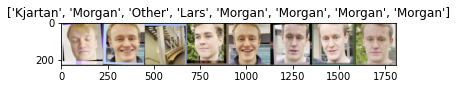

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

inputs, classes = inputs[:8], classes[:8]

print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Create a function for training and validation
The following function trains the supplied model with the loss criterion and optimizer supplied, for the specified number of epochs. During training it logs the loss and accuracy for both training and validation. Whenever a better model is found on the validation set, the function saves the model parameters to a file for use for inference later.

In [11]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    modelname = f"{type(model).__name__}-{since}"
    print(f"Training model: `{type(model).__name__}`")

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    num_img = {
        "train": 0,
        "val": 0,
    }
    
    datapoints_per_epoch = 100

    imgs_per_datapoint = {
        "train": int(float(dataset_sizes["train"] / datapoints_per_epoch)),
        "val": int(float(dataset_sizes["val"] / datapoints_per_epoch)),
    }

    print("Images per phase:", imgs_per_datapoint["train"], imgs_per_datapoint["val"])

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)
        
        with open(os.path.join(BASE_PATH, f"logs/{modelname}.csv"), "a") as f:

            # For each epoch we want to both train and evaluate in that order
            for phase in ["train", "val"]:
                if phase == "train":
                    # Makes the network ready for training, i.e. the parameters can be tuned
                    # and possible Dropouts are activated
                    model.train()
                else:
                    # Makes the network ready for inference, i.e. it is not tunable and will
                    # turn off regularization that might interfere with training
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                plot_loss = 0
                plot_corrects = 0

                plot_points = 0

                # Iterate over training or validation data
                for inputs, labels in tqdm(dataloaders[phase], desc=f"Epoch: {epoch} ({phase})", file=sys.stdout):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Reset the gradients before calculating new ones
                    optimizer.zero_grad()

                    
                    # Ask PyTorch to generate computation graph only if in training mode
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Only perform update steps if we're training
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()


                    # Save values for statistics and logging
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    plot_loss += loss.item() * inputs.size(0)
                    plot_corrects += torch.sum(preds == labels.data)
                    
                    num_img[phase] += BATCH_SIZE
                    
                    if (num_img[phase] % imgs_per_datapoint[phase]) < (BATCH_SIZE + 1):
                        f.write(f"{time.time()},{epoch},{phase},\
                        {num_img[phase]},{plot_loss / float(imgs_per_datapoint[phase])},\
                        {plot_corrects / float(imgs_per_datapoint[phase])}\n")
                        
                        plot_loss = 0
                        plot_corrects = 0
                        plot_points += 1

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
                print(f"Points plotted: {plot_points}")

                # deep copy the model
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    # This saves the data that can be loaded later for inference
                    torch.save(
                        {
                            "loss": epoch_loss,
                            "acc": epoch_acc,
                            "epoch": epoch,
                            "parameters": best_model_wts,
                        },
                        os.path.join(BASE_PATH, f"checkpoints/{modelname}.data"),
                    )
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Prepare the home-made CNN – WoodNet
Below are two networks. The first is made by the authors, and is made to be trained from scratch on the training data. The other is fully trained on ImageNet (1000 classes) and fine-tuned on the training data.

In [12]:
class WoodNet(nn.Module):
    # After 5 pooling layers the 224x224 images are reduced to 7x7
    # while 3 channels have become 64.
    size_after_conv = 7 * 7 * 64
    def __init__(self):
        super(WoodNet, self).__init__()
        self.features = nn.Sequential(   
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.classify = nn.Sequential(
            nn.Linear(self.size_after_conv, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, len(class_names)),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.size_after_conv)
        x = self.classify(x)

        return x

# Create the net
woodnet = WoodNet()
woodnet

WoodNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU()
  )
  (classify): Sequential(
    (0): Linear(in_features=3136, out_features=2048, bia

### Prepare the pretrained CNN – SqueezeNet
Below is the code for loading in the pretrained SqueezeNet. After it is loaded, the last classification layer is replaced with a one with the correct amount of output classes.

In [13]:
# Load pretrained SqueezeNet
squeezenet = models.squeezenet1_1(pretrained=True, progress=True)
# Replace the last layer with one with the correct number of channels
num_ftr = squeezenet.classifier[1].in_channels
squeezenet.classifier[1] = nn.Conv2d(num_ftr, len(class_names), 1, 1)
squeezenet

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

### Prepare a bad net – BadNet 
Below is a simple model which will be used for performance comparison with WoodNet and SqueezeNet. 




In [14]:
class BadNet(nn.Module):
    def __init__(self):
        super(BadNet, self).__init__()
        
        self.classify = nn.Sequential(
            nn.Linear(224*224*3, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, len(class_names)),
        )

    def forward(self, x):
        x = x.view(-1, 224*224*3)
        x = self.classify(x)

        return x

badnet = BadNet()
badnet

BadNet(
  (classify): Sequential(
    (0): Linear(in_features=150528, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [15]:
# Put all the different networks in a dictionary for convenient use later
networks = {
    Network.WOODNET: woodnet,
    Network.SQUEEZENET: squeezenet,
    Network.BADNET: badnet,
}

### Train the network
Below is code that instantiates the loss function and optimization method and starts the training.
To train every parameter in SqueezeNet, set `train_full_network = True`, and to `False` if only the last layer is to be trained. Set the variable network to the network that you want to train. Choices are `woodnet` and `squeezenet`.

In [ ]:
# network = networks[Network.SQUEEZENET].to(device)
# network = networks[Network.BADNET].to(device)
network = networks[Network.WOODNET].to(device)

train_full_network = False

if train_full_network or isinstance(network, (WoodNet, BadNet)):
    print("Training full network")
    parameters = network.parameters()
else:
    print("Training only last layer of SqueezeNet")
    parameters = network.classifier[1].parameters()

optimizer = torch.optim.SGD(parameters, lr=0.001, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

train_model(network, loss_function, optimizer, num_epochs=25)

### Visualize the model performance for some images

In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(network)

### Download checkpoints from previous training for evaluation
Meant to use if running the training of the models is not something you'd feel inclined to do.

In [22]:

blobnames = [
    "SqueezeNet-1605361529.9021263_cropped.data",
    "SqueezeNet-1605290736.1277423.data",
    "WoodNet-1605365270.1111202_cropped.data",
    "WoodNet-1605294933.5362356.data",
]

for blob in blobnames:
    with open(os.path.join(BASE_PATH, "checkpoints", blob), "wb") as f:
        storage.Client.create_anonymous_client().download_blob_to_file(f"{STORAGE_ROOT}/checkpoints/{blob}", f)

# Put the files in a dictionary for convenient use
saves_data = {
    Network.WOODNET: {
        Dataset.FACE: "WoodNet-1605365270.1111202_cropped.data",
        Dataset.CENTER: "WoodNet-1605294933.5362356.data",
    },
    Network.SQUEEZENET: {
        Dataset.FACE: "SqueezeNet-1605361529.9021263_cropped.data",
        Dataset.CENTER: "SqueezeNet-1605290736.1277423.data",
    },
}

### Test the trained network with example images scraped from facebook etc. Can be used by uploading images and changing the paths

('Kjartan',
 100.0,
 tensor([[9.9998e-01, 1.3955e-08, 1.1119e-05, 1.2251e-05]], device='cuda:0',
        grad_fn=<SoftmaxBackward>))

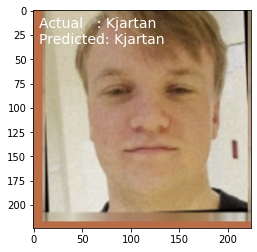

In [33]:
# This requires the training to have been run in the current session
# One could alternatively load in weights if training has not been run:
load_weights = True
if load_weights:
    network = networks[Network.SQUEEZENET]
    save_data = saves_data[Network.SQUEEZENET][Dataset.FACE]
    network.load_state_dict(torch.load(os.path.join(BASE_PATH, "checkpoints", save_data))["parameters"])
    network = network.to(device).eval()

inputs = [
    # These paths are meant as examples
    # Here one can change and add paths to one's own images and test with
    # cv2.imread("/content/lars_1.png", cv2.IMREAD_COLOR),
    # cv2.imread("/content/morgan_1.png", cv2.IMREAD_COLOR),
    cv2.imread(os.path.join(BASE_PATH, "faces", configuration[dataset]["datadir"], "test/Kjartan/kjartan_video_0_100_augmentation_4.jpg"), cv2.IMREAD_COLOR),
]


def get_prediction_image(net, img, true_lab=None, plot=False):
    assert not plot or (plot and true_lab)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    inp = cv2.resize(img, (224, 224)) / 255.0
    inp = inp / std - mean
    inp = inp.transpose((2, 0, 1))

    imgt = torch.Tensor(inp).unsqueeze(0).to(device)

    out = net(imgt)

    probabilities = F.softmax(out, dim=1)

    prob, class_idx = torch.max(probabilities, dim=1)
    pred = class_names[class_idx]

    if plot:
        plt.imshow(img)
        plt.text(5, 17,   f"Actual   : {true_lab}", color="white", fontsize=14)
        plt.text(5, 34,   f"Predicted: {pred}", color="white", fontsize=14)

    return pred, round(prob.item() * 100, 2), probabilities

get_prediction_image(network, inputs[0], "Kjartan", plot=True)

### Plot example of prediction with and without cropping to face

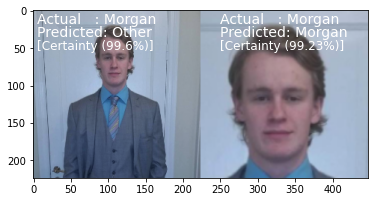

In [35]:
images = [
    "morgan_1_uncropped.png",
    "morgan_1_cropped.png",
]

for blob in images:
    with open(os.path.join(BASE_PATH, "examples", blob), "wb") as f:
        storage.Client.create_anonymous_client().download_blob_to_file(f"{STORAGE_ROOT}/examples/{blob}", f)

inputs = [cv2.imread(os.path.join(BASE_PATH, "examples", img), cv2.IMREAD_COLOR) for img in images]
inputs = list(map(lambda x: cv2.cvtColor(cv2.resize(x, (224, 224)), cv2.COLOR_BGR2RGB), inputs))

network = networks[Network.SQUEEZENET]
save_data = saves_data[Network.SQUEEZENET][Dataset.CENTER]
network.load_state_dict(torch.load(os.path.join(BASE_PATH, "checkpoints", save_data))["parameters"])
network = network.to(device).eval()

plt.imshow(np.concatenate((inputs[0], inputs[1]), axis=1))
(pred, prob, _), actual = get_prediction_image(network, inputs[0]), "Morgan"
plt.text(5, 17,   f"Actual   : {actual}", color="white", fontsize=14)
plt.text(5, 34,   f"Predicted: {pred}", color="white", fontsize=14)
plt.text(5, 52,   f"[Certainty ({prob}%)]", color="white", fontsize=12)


(pred, prob, _), actual = get_prediction_image(network, inputs[1]), "Morgan"
plt.text(249, 17, f"Actual   : {actual}", color="white", fontsize=14)
plt.text(249, 34, f"Predicted: {pred}", color="white", fontsize=14)
plt.text(249, 52,   f"[Certainty ({prob}%)]", color="white", fontsize=12)

plt.savefig("morgan_crop_plot.png")
plt.show();

### Code for calculating the accuracy, loss, precision, and recall for all the networks and datasets
Each time the cell is run you must choose one of the four configurations, i.e. WoodNet or SqueezeNet and cropped to face or center.

In [ ]:
# Load saved data from a training run
# and initialize model weights to the saved weights
# Choose net and dataset
net_type = Network.SQUEEZENET
data_type = Dataset.CENTER

network = networks[net_type]
save_data = saves_data[net_type][data_type]
network.load_state_dict(torch.load(os.path.join(BASE_PATH, "checkpoints", save_data))["parameters"])
network = network.to(device).eval()

running_loss = 0
running_corrects = 0

# Define what classes have access
access = set([0, 1, 2])

# Counters for true positives, false positives, and false negatives
tp = 0
fp = 0
fn = 0

for inputs, labels in tqdm(dataloaders["test"]):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():

        outputs = network(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_function(outputs, labels)

        # Save values for statistics and logging
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        for pred, lab in zip(preds, labels):
            pred, lab = pred.item(), lab.item()
            if lab in access and pred in access:
                tp += 1
            elif lab in access and pred not in access:
                fn += 1
            elif lab not in access and pred in access:
                fp += 1


# Loss
print(running_loss / dataset_sizes["test"])

# Accuracy
print(running_corrects.double() / dataset_sizes["test"])

# Precision
print(tp / (tp + fp))

# Recall
print(tp / (tp + fn))

### Create confusion matrix for the WoodNet, SqueezeNet, and BadNet

Below is a function which returns all true lables and a models predicted values

In [38]:
@torch.no_grad()
def get_all_preds_labels(model, loader):
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)

    for inputs, labels in tqdm(loader):
        labels = labels.to(device)
        inputs = inputs.to(device)

        preds = model(inputs)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_labels = torch.cat(
            (all_labels, labels)
            ,dim=0
        )
    return all_preds, all_labels


In [41]:
 #[actual,predicted]
 stacked = torch.stack(
    (
        test_labels
        ,test_preds.argmax(dim=1)
    ),
    dim=1,
)
stacked.shape

torch.Size([23442, 2])

This is a convolutional matrix in tensor form, not used for the visualisation, but we provide it as it can be useful in some cases

In [42]:
def cm_tensor(stacked):
  cm_tensor = torch.zeros(4,4, dtype=torch.int64)
  for pair in stacked:
    al,pl = pair.tolist()
    cm_tensor[int(al),int(pl)] = cm_tensor[int(al),int(pl)] + 1
  

In [43]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


The plotting is done on the cpu. As such we return our calculated test predictions and acutal labels to be calculated on the cpu. 

In [44]:

test_labels = test_labels.cpu()
test_preds = test_preds.cpu()

cm = confusion_matrix(test_labels, test_preds.argmax(dim=1))


The below plotter is based on the code from DeepLizard: https://deeplizard.com/learn/video/0LhiS6yu2qQ?fbclid=IwAR1Zb3LSBe4nhuxa6OhwpW4-rXwg7LhMIeG0C0iCWMrYLH2Bkhfh-z5IaL0 

In [45]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, filename, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print(filename)
    plt.savefig(filename)
# plot_confusion_matrix(cm,class_names)

In [ ]:
#test_preds, test_labels = get_all_preds_labels(model,dataloader_and_type)
def cnn_constructor(preds,labels,filename,title): 
    stacked = torch.stack(
      (
          labels
          ,preds.argmax(dim=1)
      )
      ,dim=1
    )
    labels = labels.cpu()
    preds = preds.cpu()
    cm = confusion_matrix(labels, preds.argmax(dim=1))
    plot_confusion_matrix(cm,class_names,filename,title=title)

# Below is code for getting confusion matrix for each of the networks
# Uncomment one at a time to get corresponding confusion matrix

# SqueezeNet
# test_preds_s, test_labels_s = get_all_preds_labels(squeezenet, dataloaders["test"])
# cnn_constructor(test_preds_s, test_labels_s, "/content/squeezenet_cm.png", title="SqueezeNet Confusion Matrix");

# WoodNet
test_preds_w, test_labels_w = get_all_preds_labels(woodnet,dataloaders["test"])
cnn_constructor(test_preds_w, test_labels_w, "/content/woodnet_cm.png", title="WoodNet Confusion Matrix");

# BadNet
# test_preds_b ,test_labels_b = get_all_preds_labels(badnet,dataloaders["test"])
#cnn_constructor(test_preds_b, test_labels_b, "/content/badnet_cm.png", title="BadNet Confusion Matrix");
